# Estimation de densité, K plus proches voisins

In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl
from sklearn import metrics as sk
cdict={
  'red'  :  ( (0.0, 0.25, .25), (0.02, .59, .59), (1., 1., 1.)),
  'green':  ( (0.0, 0.0, 0.0), (0.02, .45, .45), (1., .97, .97)),
  'blue' :  ( (0.0, 1.0, 1.0), (0.02, .75, .75), (1., 0.45, 0.45))}

cm=mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 1024)


On lit les données du fichier Vélib

In [38]:
fname="velib-enpc.npz"
with  np.load(fname) as obj:
    # Dictionnaire des informations des stations idvelib->(nom,adresse,x,y,nbre attaches,long,lat)
    stations = dict(obj['stations'].tolist())
    # Correspondance idvelib->ligne matrice
    stations_idx = dict(obj['stations_idx'].tolist())
    # Correspondance ligne matrice->idvelib
    idx_stations = dict(obj['idx_stations'].tolist())
    # Matrice du nombre de velos dispo par station par minute
    histo = obj['histo']

parismap = mpimg.imread("paris.jpg")

# Permet d'afficher la carte de Paris
def show_map():
    plt.imshow(parismap,extent=[0,1,0,1],aspect=0.6)



### Q 2.1 La matrice geo_data contient une station par ligne et 3 colonnes : les coordonnées x, y et le nombre d’attaches (nombre de vélos théoriquement disponibles). Afficher les stations et la carte de Paris en arrière plan à l’aide du code fourni.


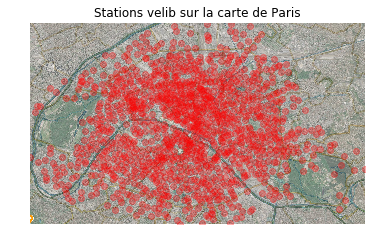

In [39]:
geo_data = np.array([ [x[2],x[3],x[4]] for x in stations.values()])
plt.scatter(geo_data[:,0],geo_data[:,1],alpha=0.3,color="red")
plt.title('Stations velib sur la carte de Paris')
plt.axis('off')
show_map()


### Calculer l’histogramme de ps(x, y) qui correspond à la densité spatiale de l’offre vélib théorique en utilisant une grille de discrétisation de 10 × 10. Afficher le résultat en utilisant la commande plt.imshow(resultat,extent=[0,1,0,1],interpolation=’none’,alpha=0.3,origin = "lower",aspect=0.6) (faire attention de prendre la transposée de la matrice resultat selon le sens de calcul de l’histogramme).  Comparer à la répartition des stations vélibs. Réitérer sur plusieurs autres discrétisations spatiales.

In [40]:
# Nombre de vélib total pour calculer la densité
nb_total_velibs= float(sum(geo_data[:,2]))

(-0.056619331231827955, 1.0573556568379725, -0.056438557763061087, 1.0)

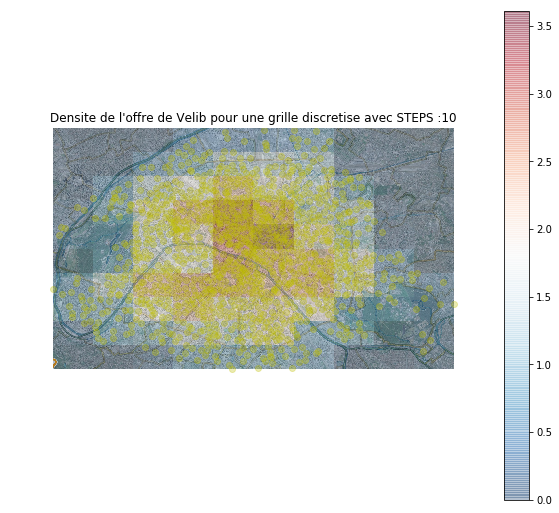

In [41]:
#### Constantes Histogramme
# Maillage 10 par 10
STEPS =  10
geo_exemple= np.zeros((STEPS,STEPS))

#resultat = densite de vélib
# On parcours les stations et on actualise l'histogramme
for station in geo_data :
    indx = int(station[0]*STEPS)
    indy = int(station[1]*STEPS)
    if (indx<STEPS) and (indy<STEPS):
        geo_exemple[indx, indy] += float(station[2])*(STEPS*STEPS)/(nb_total_velibs)

plt.figure(figsize=(10,9))
show_map()
plt.imshow(geo_exemple.T,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin = "lower",aspect=0.6,cmap=plt.cm.get_cmap('RdBu_r'))
plt.colorbar()
plt.scatter(geo_data[:,0],geo_data[:,1],alpha=0.3,color="y")
title="Densite de l'offre de Velib pour une grille discretise avec STEPS :"+str(STEPS)
plt.title(title)
plt.axis('off')


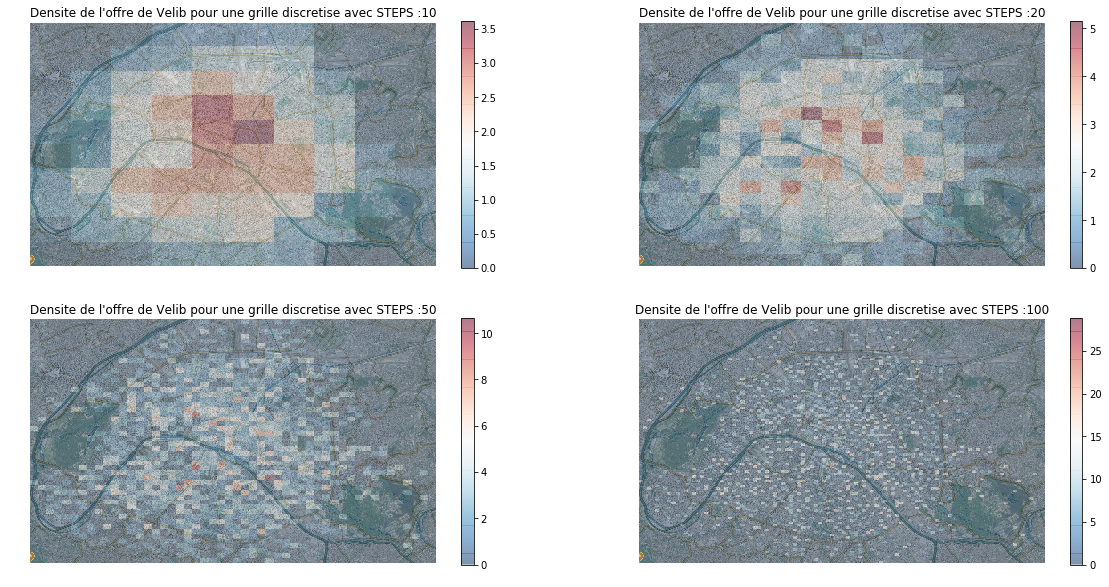

In [42]:
STEPS=[10, 20, 50, 100]
plt.figure(figsize=(20,10))
i=1
for STEP in STEPS:
    geo_exemple= np.zeros((STEP,STEP))
    #resultat = densite de vélib
    for station in geo_data :
        indx = int(station[0]*STEP)
        indy = int(station[1]*STEP)
        if (indx<STEP) and (indy<STEP):
            geo_exemple[indx, indy] += float(station[2])*(STEP*STEP)/(nb_total_velibs)
    plt.subplot(2,2,i)
    i += 1
    show_map()
    plt.imshow(geo_exemple.T,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin = "lower",aspect=0.6,cmap=plt.cm.get_cmap('RdBu_r'))
    plt.colorbar()
    plt.axis('off')
    title="Densite de l'offre de Velib pour une grille discretise avec STEPS :"+str(STEP)
    plt.title(title)

On remarque bien que l'échelle des densités varie énormément en fonction de l'hyperparamètre, en effet plus on prend un pas petit, plus on va centrer le maillage sur une seule station.

### Q 2.3 Que remarquez vous par rapport à la stabilité des résultats ? De combien de paramètres est composé le modèle ? Comment évolue ce nombre de paramètres en fonction du nombre de dimension ? du pas de discrétisation ? Conclure sur les avantages et faiblesses de la méthode.

Les résultats sont très instables en fonction du pas, par exemple
r les effets de bord. En effet si une station se trouve à la limite d'une case d'un maillage, en changeant le pas de discrétisation elle peut très bien sortir. De plus plus on va prendre un pas petit, plus on va avoir des zones de densité nulles ie il n'y a aucune stations dans cette case. 
Le nombre de paramètre varie comme la dimension du problème, en effet on peut très bien choisir un pas différent selon les dimensions.
Cette méthode est très facile à implémenter et ne demande qu'un parcours linéaire des données, néanmoins elle reste très instable à l'hyperparamètre.


### Q 2.4 Implémenter les fonctions uni(x,data,sigma) et gaussian(x,data,sigma) qui prennent en entrée une donnée x, une matrice data de taille n × d d’exemples et le paramètre sigma et renvoient un vecteur de taille n, la valeur du noyau uniforme/gaussien en $K (\frac{ x−data[i]}{ σ }) $ (sans boucle for).

In [43]:
def uni(x,data,sigma):
    res=abs(data-x)/sigma
    res=np.amin(res, axis=1)
    return (-0.5*np.sign(res-0.5)+0.5).reshape(-1,1)
        

In [44]:
def gaussian(x,data,sigma):
    d=data.shape[1]
    res=(data-x)/sigma
    res=np.power(np.linalg.norm(res, axis=1),2)
    res=np.exp(-0.5*res)/(np.power((2*np.pi),d/2.))
    return res.reshape(-1,1)
                          

### Q 2.5 Implémenter la fonction parzen(x,data,weight,sigma,kernel) qui renvoie l’estimation de la densité au point x de dimension d pour un échantillon data de taille n × d pondéré par le vecteur weight de taille n en utilisant la fonction noyau kernel.



In [45]:
def parzen(x,data,weight,sigma,kernel):
    weight=weight.reshape(-1,1)
    res=weight.T.dot(kernel(x,data,sigma))/(np.power(sigma,data.shape[1])*np.sum(weight))
    return res
    


### Q 2.6 Expérimenter les deux noyaux. Faites varier le paramètre. Que remarquez vous quand celui-ci tend vers 0 ? vers l’infini ?

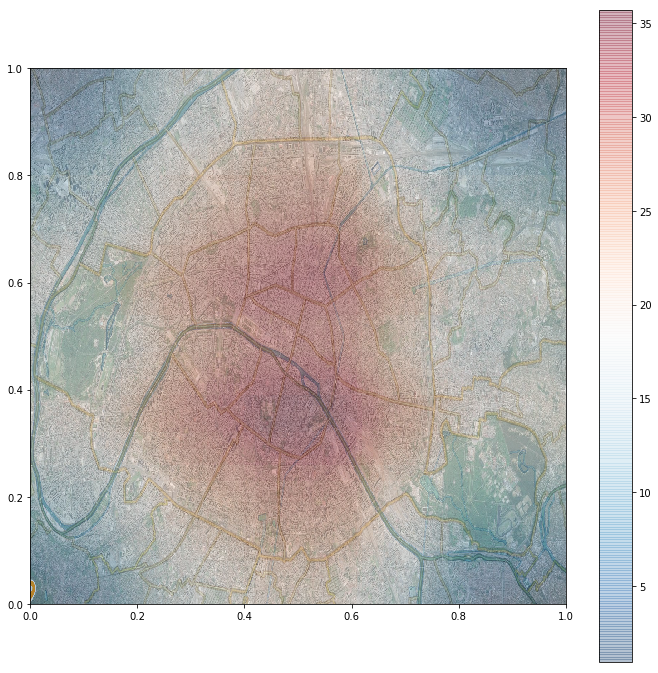

In [46]:
#Evaluer une densite 2d sur une discretisation de pas STEPS de [0,1]^2
STEPS=100
xx,yy=np.meshgrid(np.linspace(0,1,STEPS),np.linspace(0,1,STEPS))
grid = np.c_[xx.ravel(),yy.ravel()]
sigma=0.1
pdf=np.array([parzen(g,geo_data[:,:2],geo_data[:,2],sigma,uni) for g in grid]).reshape((STEPS,STEPS))
plt.figure(figsize=(12,12))
show_map()
plt.imshow(pdf,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin="lower",cmap=plt.cm.get_cmap('RdBu_r'))
plt.colorbar()

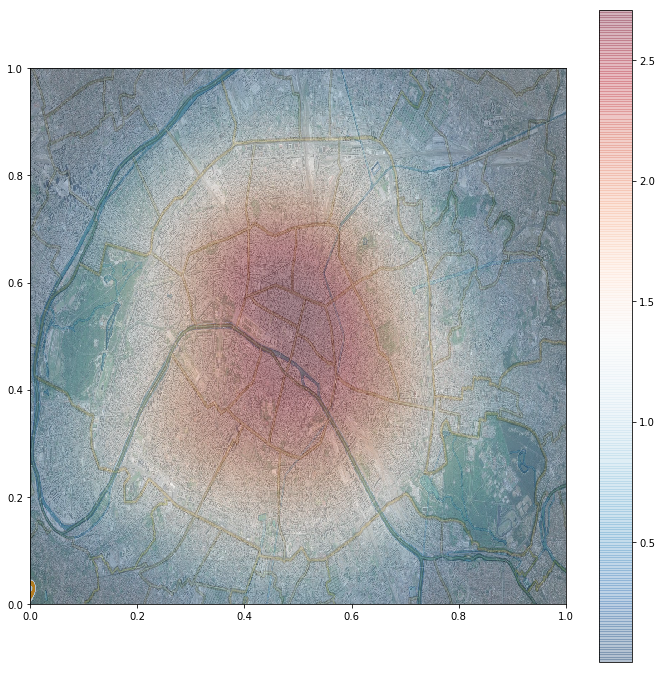

In [47]:
#Evaluer une densite 2d sur une discretisation de pas STEPS de [0,1]^2
STEPS=100
xx,yy=np.meshgrid(np.linspace(0,1,STEPS),np.linspace(0,1,STEPS))
grid = np.c_[xx.ravel(),yy.ravel()]
sigma=0.1
pdf=np.array([parzen(g,geo_data[:,:2],geo_data[:,2],sigma,gaussian) for g in grid]).reshape((STEPS,STEPS))
plt.figure(figsize=(12,12))
show_map()
plt.imshow(pdf,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin="lower",cmap=plt.cm.get_cmap('RdBu_r'))
plt.colorbar()

On observe déjà que en prenant le même hyperparamètre sigma, on obtient des densités complétement différentes, en effet le noyau uniforme 'assigne un poids 1' sur toutes les stations de son entourage alors que le noyau gaussien donne moins d'importance en  fonction de la distance

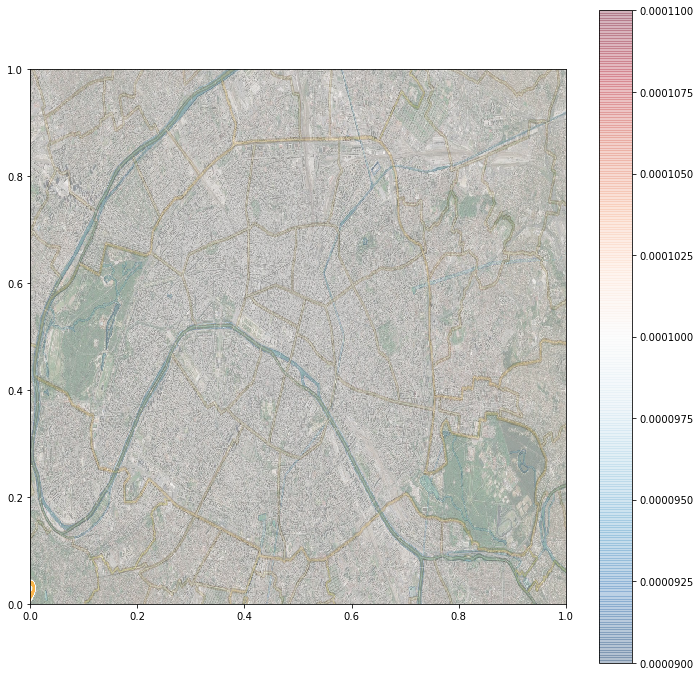

In [48]:
#Evaluer une densite 2d sur une discretisation de pas STEPS de [0,1]^2
STEPS=100
xx,yy=np.meshgrid(np.linspace(0,1,STEPS),np.linspace(0,1,STEPS))
grid = np.c_[xx.ravel(),yy.ravel()]
sigma=100
pdf=np.array([parzen(g,geo_data[:,:2],geo_data[:,2],sigma,uni) for g in grid]).reshape((STEPS,STEPS))
plt.figure(figsize=(12,12))
show_map()
plt.imshow(pdf,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin="lower",cmap=plt.cm.get_cmap('RdBu_r'))
plt.colorbar()

En prenant un sigma trop grand, on a tendance à moyenner sur l'offre sur l'ensemble de la carte et d'obtenir une densité uniforme comme si dessus.

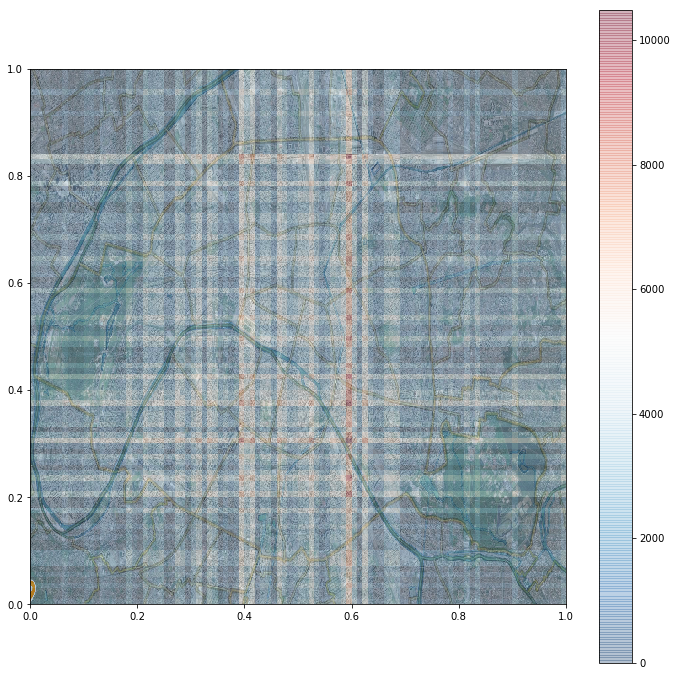

In [49]:
#Evaluer une densite 2d sur une discretisation de pas STEPS de [0,1]^2
STEPS=100
xx,yy=np.meshgrid(np.linspace(0,1,STEPS),np.linspace(0,1,STEPS))
grid = np.c_[xx.ravel(),yy.ravel()]
sigma=0.001
pdf=np.array([parzen(g,geo_data[:,:2],geo_data[:,2],sigma,uni) for g in grid]).reshape((STEPS,STEPS))
plt.figure(figsize=(12,12))
show_map()
plt.imshow(pdf,extent=[0,1,0,1],interpolation='none',alpha=0.3,origin="lower",cmap=plt.cm.get_cmap('RdBu_r'))
plt.colorbar()

En prenant un sigma trop faible, on fait le contraire et on estime que la densité sur un voisinage trop proche de la station

### Q 2.7 Pourquoi les moindres carrés sont difficiles à appliquer pour évaluer l’estimation ? Proposer une mesure d’évaluation basée sur la vraisemblance. Comparer les résultats des différents noyaux et des différents paramétrages.

On ne peut pas utiliser les moindres carrés car on cherche  à estimer une densité. L'approche des moindres carrés se ferait sur la différence entre le nombre de vélib à une stations et l'estimation : $ \sum_{i=1}^{N}(y(i)-d(x_i))^{2}$ Des noyaux centrés sur les stations maximiseraient cette approche. 
On considère plutot la fonction de perte de la log-vraisemblance. Le critère d'optimalité est de maximiser :
$ \sum_{x \in \chi } log(d(x)| \sigma) $

In [82]:
def log_likehood(kernel,sigma):
    STEPS=100
    xx,yy=np.meshgrid(np.linspace(0,1,STEPS),np.linspace(0,1,STEPS))
    grid = np.c_[xx.ravel(), yy.ravel()]
    pdf=np.array([parzen(g, geo_data[:,:2], geo_data[:,2], sigma,kernel)+1 for g in grid])
    return np.log(pdf).sum()
    

/home/alberge-leo/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in divide
  
/home/alberge-leo/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in divide
  
/home/alberge-leo/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in divide
  This is separate from the ipykernel package so we can avoid doing imports until


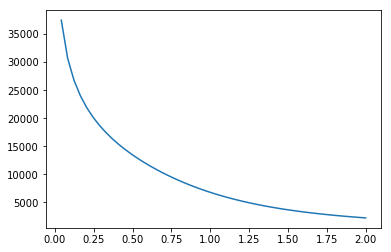

In [83]:
sigmas = np.linspace(0,10, 100)
loglik=[]
for sigma in sigmas:
    loglik.append(log_likehood(uni,sigma))
    
plt.plot(sigmas, loglik)

### Q 2.8 Construire la matrice take contenant le nombre de vélos empruntés aux stations par minute. Tracer pour quelques journées et pour quelques stations le nombre d’emprunts par minute. Voyez-vous une différence entre stations ? entre journées ? entre jour ouvert et week-end ? Quelle(s) hypothèse(s) de régularité peut-on faire pour modéliser la demande ?

On construit la demande 'positive' en faisant la différence entre le nombre de vélos empruntés entre 2 dates. On en prend la partie positive

In [45]:
take = np.zeros((histo.shape[0],histo.shape[1]-1))
i=0
for station_id in stations.keys():
    take[i,:] = np.maximum( 0, histo[stations_idx[station_id],1:histo.shape[1]] - histo[stations_idx[station_id],:histo.shape[1]-1])
    i+=1


In [46]:
nb_minutes_day = 1440

In [47]:
def plot_taken(dayID, stationID):
    x=np.linspace((dayID-1)*nb_minutes_day,dayID*nb_minutes_day,1440)-(dayID-1)*1440
    plt.plot(x/60,take[stationID,(dayID-1)*nb_minutes_day:dayID*nb_minutes_day],label=DAYS[(dayID-1)%7+1])
#     plt.plot(x/60,taken[stationID,(dayID-1)*nb_minutes_day:dayID*nb_minutes_day])
    plt.legend()
    

In [48]:
DAYS={1:'Lundi',2:'Mardi',3:'Mercred',4:'Jeud',5:'Vendredi',6:'Samedi',7:'Dimanche'}

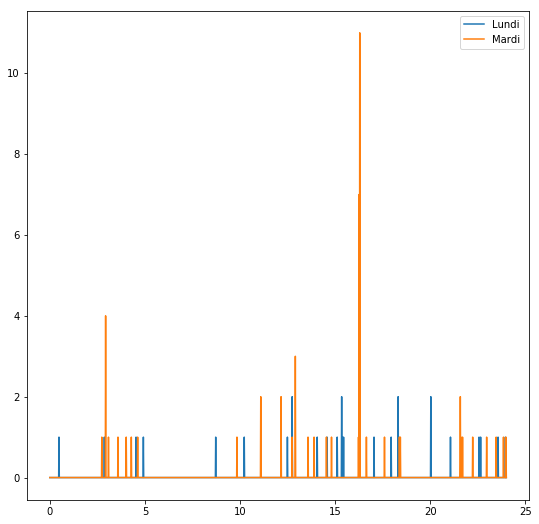

In [49]:
plt.figure(figsize=(9,9))
for i in range(1,3):
    plot_taken(i,1000)



On peut faire l'hypothèse de réguralité que la demande est la même du lundi au vendredi et la meme le weekend.

### Q 2.9 Implémenter l’estimateur de Nadaraya-Watson. Expérimenter sur la demande pour une station sur une journée, puis en agrégeant plusieurs journées de la même station. Observer l’évolution en fonction de l’ajout de données. Interpréter le rôle de σ et le choix du noyau.

In [50]:
def nadaraya_watson(x, data, weight, sigma, kernel):
    weight=weight.reshape(-1,1)
    res=weight.T.dot(kernel(x,data,sigma))
    return res

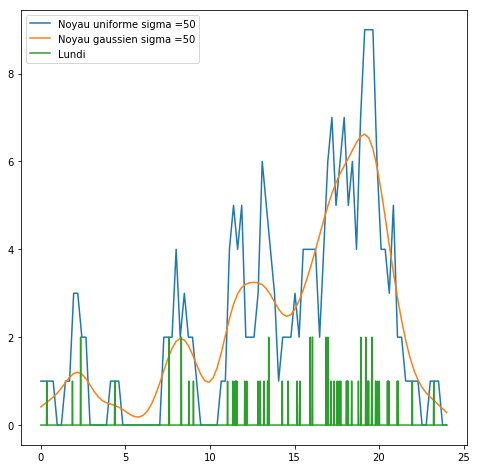

In [56]:
#Evaluer une densite 2d sur une discretisation de pas STEPS de [0,1]^2
STEPS=100
stationID=0
dayID=1
x = np.linspace(0,nb_minutes_day,1440).reshape(-1,1)
tt = np.linspace(0,1440,STEPS)
sigma=50
pdf=np.array([nadaraya_watson(t,x,take[stationID,(dayID-1)*nb_minutes_day : dayID*nb_minutes_day],sigma,uni) for t in tt]).reshape(-1,STEPS)
pdf2=np.array([nadaraya_watson(t,x,take[stationID,(dayID-1)*nb_minutes_day : dayID*nb_minutes_day],sigma,gaussian) for t in tt]).reshape(-1,STEPS)

plt.figure(figsize=(8, 8))
plt.plot(tt/60,pdf[0], label='Noyau uniforme sigma =50')
plt.plot(tt/60,pdf2[0], label='Noyau gaussien sigma =50')

plot_taken(1,0)

Pour le noyau gaussien, on obtient une courbe plus lisse que pour le noyau uniforme. Sigma décrit sur quelle période il faut pondérer la demande. Idem que dans la partie 1


On va maintenant agréger des journées ensemble pour voir l'évolution de la demande.

In [71]:
def aggregate_days(stationID, firstday, lastday, take):
    #Aggregation des données de la station stationID de firstday a lastday
    x = np.linspace(0,nb_minutes_day,1440).reshape(-1,1)
    x = np.concatenate([x for i in range(firstday, lastday+1)])
    
    y = np.concatenate([take[stationID, (dayID-1)*nb_minutes_day:dayID*nb_minutes_day] 
                   for dayID in range(firstday, lastday+1)]).reshape(-1,1)
    return x,y

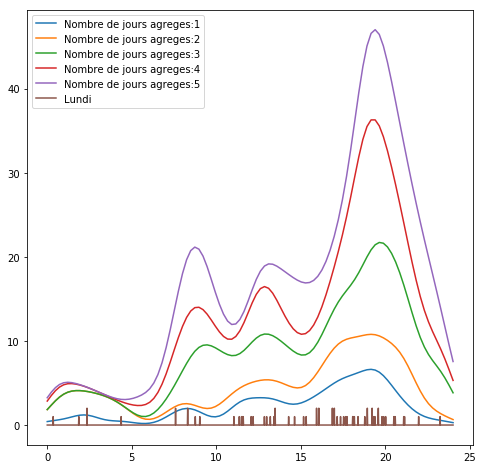

In [79]:
STEPS=100
stationID=0
plt.figure(figsize=(8, 8))

for dayID in range(1,6):

    x,y =aggregate_days(0,1,dayID,take)
    tt = np.linspace(0,1440,STEPS)
    sigma=50
    pdf=np.array([nadaraya_watson(t,x,y,sigma,gaussian) for t in tt]).reshape(-1,STEPS)
    label='Nombre de jours agreges:'+ str(dayID)
    plt.plot(tt/60,pdf[0], label=label)

plot_taken(1,0)

### Q 2.10 Comme souvent en régression, les moindres carrés sont utilisés pour l’évaluation des modèles. Que doit-on considérer comme découpage des données en ensemble apprentissage et test afin de pouvoir faire de la sélection de modèles ? Expérimenter afin de déterminer le meilleur paramètre. Est-il constant sur chaque station ? Pour chaque jour ?